# 📌 Generate Sample Data

In [1]:
import pandas as pd
import numpy as np

# Set random seed for reproducibility
np.random.seed(42)

# Simulate a dataset for customers
n_samples = 5000

df = pd.DataFrame({
    'credit_score': np.random.randint(500, 850, n_samples),  # Credit score range
    'income': np.random.randint(30000, 150000, n_samples),  # Annual income
    'current_limit': np.random.randint(1000, 20000, n_samples),  # Current credit limit
    'spend': np.random.uniform(500, 10000, n_samples),  # Monthly spend
    'churn': np.random.choice([0, 1], size=n_samples, p=[0.9, 0.1]),  # Whether the customer churned
    'default': np.random.choice([0, 1], size=n_samples, p=[0.95, 0.05]),  # Whether the customer defaulted
    'increase_limit': np.random.choice([0, 1], size=n_samples, p=[0.5, 0.5])  # Whether limit was increased
})

# Create a new column for Target Variable: Additional Spend (Proxy for LTV)
df['additional_spend'] = df['spend'] * (1 + 0.2 * df['increase_limit'])  # 20% more spend if limit increased

# Show sample data
df.head()


,credit_score,income,current_limit,spend,churn,default,increase_limit,additional_spend
0,602,99460,11874,9829.423916,0,0,1,11795.308700
1,848,87767,7163,1414.341666,0,0,0,1414.341666
2,770,58054,6264,6097.511373,0,1,1,7317.013647
3,606,105319,18615,6451.406625,0,0,1,7741.687950
4,571,132789,16890,5611.755657,0,0,0,5611.755657


# Step 2: Define Treatment & Outcome Variables
We define:

- Treatment Variable (T): increase_limit (1 if credit limit increased, 0 otherwise)
- Outcome Variable (Y): additional_spend (how much spending changed)

In [2]:
# Define Features (X), Treatment (T), and Outcome (Y)
X = df[['credit_score', 'income', 'current_limit', 'spend', 'churn', 'default']]  # Customer attributes
T = df['increase_limit']  # Treatment (1 = Credit limit increase, 0 = No increase)
Y = df['additional_spend']  # Outcome (Spending behavior change)


# Step 3: Train the T-Learner
A T-Learner involves training two separate models:

- One model (T=1) for customers who received a credit limit increase.
- Another model (T=0) for customers who didn’t receive a credit limit increase.

# 📌 Split Data into Train & Test

In [3]:
from sklearn.model_selection import train_test_split

# Split into training and test sets (80% train, 20% test)
X_train, X_test, T_train, T_test, Y_train, Y_test = train_test_split(X, T, Y, test_size=0.2, random_state=42)


# 📌 Train Separate Models for Treated & Untreated Groups

In [8]:
from lightgbm import LGBMRegressor

# Train Model for Treated Group (T=1)
treated_model = LGBMRegressor(n_estimators=100, max_depth=3, random_state=42)
treated_model.fit(X_train[T_train == 1], Y_train[T_train == 1])

# Train Model for Untreated Group (T=0)
untreated_model = LGBMRegressor(n_estimators=100, max_depth=3, random_state=42)
untreated_model.fit(X_train[T_train == 0], Y_train[T_train == 0])


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1011
[LightGBM] [Info] Number of data points in the train set: 1944, number of used features: 6
[LightGBM] [Info] Start training from score 6320.837304
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

LGBMRegressor(max_depth=3, random_state=42)

# Step 4: Estimate Counterfactuals & Compute CATE
Now that we have trained separate models for Treated (T=1) and Untreated (T=0) groups, we can:

- Predict spending behavior (Y) if limit was increased.
- Predict spending behavior (Y) if limit was NOT increased.
- Compute the Conditional Average Treatment Effect (CATE)

In [9]:
# Predict Outcomes for Both Scenarios
preds_T1 = treated_model.predict(X_test)  # If credit limit was increased
preds_T0 = untreated_model.predict(X_test)  # If credit limit was NOT increased

# Compute Conditional Average Treatment Effect (CATE)
CATE = preds_T1 - preds_T0

# Add CATE to test dataframe
df_test = df.iloc[X_test.index].copy()
df_test['CATE'] = CATE


# Step 5: Identify "Good Candidates" for Limit Increase
We now select customers who are most likely to benefit from a limit increase.

✅ Good candidates for credit limit increase:

- CATE > $1000 (spending increase is high)
- Low default risk (default == 0)
- High churn risk (churn == 1)

## 📌 Identify Customers for Limit Increase

In [16]:
# Add Predicted Spending for Both Scenarios to df_test
df_test['Predicted_Spending_T1'] = preds_T1  # If the customer received a credit limit increase
df_test['Predicted_Spending_T0'] = preds_T0  # If the customer did NOT receive a credit limit increase

df_test['good_candidate'] = (df_test['CATE'] > 1000) & (df_test['default'] == 0) & (df_test['churn'] == 0)

# Show top candidates for limit increase
df_test[df_test['good_candidate']].head()


,credit_score,income,current_limit,spend,churn,default,increase_limit,additional_spend,CATE,good_candidate,Predicted_Spending_T1,Predicted_Spending_T0
1055,622,50827,1432,9142.323963,0,0,1,10970.788756,1797.823687,True,10905.157365,9107.333678
705,562,134940,16160,5306.841627,0,0,1,6368.209952,1079.642169,True,6328.351763,5248.709594
106,634,79422,10727,6161.304715,0,0,1,7393.565658,1266.827497,True,7407.383204,6140.555708
589,669,100469,10546,5761.393701,0,0,1,6913.672441,1162.559653,True,6914.177209,5751.617556
1600,757,126502,5888,6443.838216,0,0,0,6443.838216,1306.266298,True,7756.562062,6450.295764


# Step 6: Visualize the Distribution of CATE
To understand the impact of limit increases across customers, let's plot CATE Distribution.

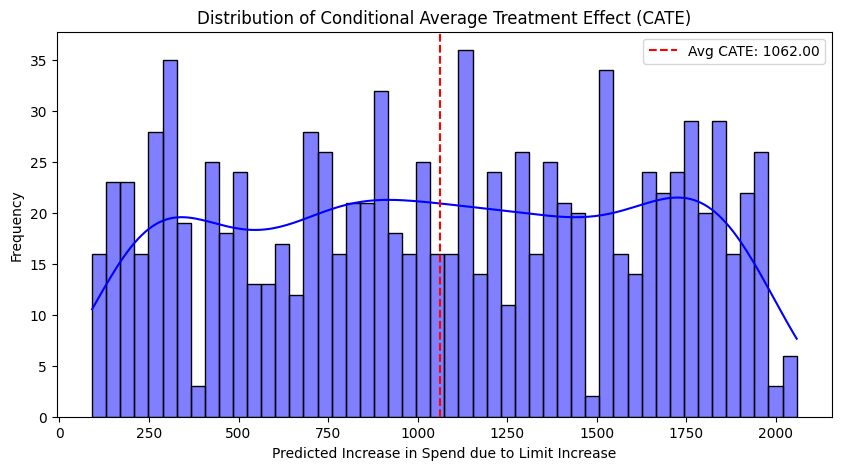

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
sns.histplot(df_test['CATE'], bins=50, kde=True, color='blue')

# Mark the average effect with a red dashed line
plt.axvline(x=df_test['CATE'].mean(), color='red', linestyle='--', label=f'Avg CATE: {df_test["CATE"].mean():.2f}')

plt.title("Distribution of Conditional Average Treatment Effect (CATE)")
plt.xlabel("Predicted Increase in Spend due to Limit Increase")
plt.ylabel("Frequency")
plt.legend()
plt.show()


## 📌 What This Graph Tells Us:
- ✅ Most customers have a positive CATE → This suggests that increasing limits is generally beneficial for spending.
- ✅ The spread is wide (from ~0 to 2000+) → Different customers have different responses, meaning some customers benefit more than others.

In [15]:
approved_customers = df_test[df_test['good_candidate']]
print(f"Total customers recommended for limit increase: {len(approved_customers)}")


Total customers recommended for limit increase: 453


# Compare Predicted vs. Actual Spending Change

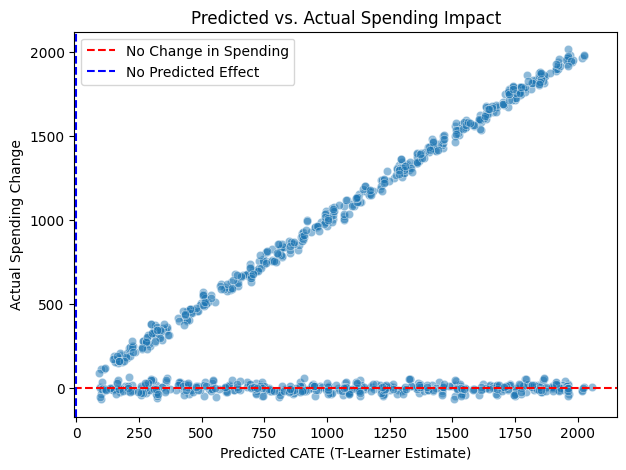

In [17]:
df_test['actual_effect'] = df_test['additional_spend'] - df_test['Predicted_Spending_T0']  # Real-world change

plt.figure(figsize=(7, 5))
sns.scatterplot(x=df_test['CATE'], y=df_test['actual_effect'], alpha=0.5)

plt.axhline(y=0, color='red', linestyle='--', label='No Change in Spending')
plt.axvline(x=0, color='blue', linestyle='--', label='No Predicted Effect')

plt.xlabel("Predicted CATE (T-Learner Estimate)")
plt.ylabel("Actual Spending Change")
plt.title("Predicted vs. Actual Spending Impact")
plt.legend()
plt.show()


In [18]:
ATE = df_test['CATE'].mean()
print(f"Average Treatment Effect (ATE): {ATE:.2f}")


Average Treatment Effect (ATE): 1062.00


In [19]:
import numpy as np

# Calculate average actual spend increase for "good candidates" vs. others
good_candidates = df_test[df_test['good_candidate'] == True]['actual_effect'].mean()
others = df_test[df_test['good_candidate'] == False]['actual_effect'].mean()

print(f"Avg Spending Increase (Good Candidates): ${good_candidates:.2f}")
print(f"Avg Spending Increase (Others): ${others:.2f}")
print(f"Uplift: {good_candidates - others:.2f}")


Avg Spending Increase (Good Candidates): $759.81
Avg Spending Increase (Others): $363.20
Uplift: 396.61
